## AutoEncoder for anomaly detection
An autoencoder is a special type of neural network that is trained to copy its input to its output. It first encodes the sample into a lower dimensional latent representation, then decodes the latent representation back to a sample.

To use an autoencoder for anomaly detection, you compare the reconstructed version of sample with its source input. If the reconstructed version of sample differs greatly from its input, the sample is anomalous in some way.


In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import torch
import matplotlib
import matplotlib.pyplot as plt
import glob
from sklearn.preprocessing import StandardScaler    # For feature normalization 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from torchsummary import summary
from sklearn.metrics import confusion_matrix, roc_curve, ConfusionMatrixDisplay
from sklearn import metrics

# Dataset preparation

In [2]:
#reading features or annotations from CSV files and concatenate them
def my_data(file_list):
    dfs = (pd.read_csv(file) for file in file_list)   #read csv files of each baby folder(use generator instead of list to occupy less memory)
    df_concat = pd.concat(dfs, ignore_index=True)   #concatenate files of each baby to a unit one
    df_final = df_concat.loc[(df_concat["seizure"] != 2) & (df_concat["seizure"] != 3 )]  #remove artifacts and disagreed annotatons
    df_final = df_final.dropna()
    df_final = df_final.reset_index(drop=True)     #reset the indexes after removing rows
    return df_final

In [3]:
df_train1 = my_data(glob.glob('path/train/*.csv'))
df_train = df_train1.loc[df_train1['seizure'] == 0]       #choose only normal class(non-seizure)
df_val = my_data(glob.glob('path/validation/*.csv'))
df_test = my_data(glob.glob('path/test/*.csv'))
print(len(df_train),len(df_test), len(df_val))

18357 5564 4460


In [4]:
x_train_r =  df_train.drop(columns=['seizure'])
y_train = df_train['seizure'] 
x_val_r =  df_val.drop(columns=['seizure'])
y_val = df_val['seizure'] 
x_test_r =  df_test.drop(columns=['seizure'])
y_test = df_test['seizure'] 

In [5]:
#data standardization
scaler = StandardScaler()
Fit = scaler.fit(x_train_r)  
x_train1 = Fit.transform(x_train_r)       # normalizing the features
x_train = pd.DataFrame(x_train1, columns=x_train_r.columns)      #change to dataframe format again
x_val1 = Fit.transform(x_val_r)         # normalizing the features
x_val = pd.DataFrame(x_val1, columns=x_val_r.columns)      #change to dataframe format again
x_test1 = Fit.transform(x_test_r)         # normalizing the features
x_test = pd.DataFrame(x_test1, columns=x_test_r.columns)      #change to dataframe format again

In [6]:
#transform to tensor
feature_train = torch.tensor(x_train.values, dtype=torch.float, requires_grad=True)
target_train = torch.tensor(y_train.values, dtype=torch.int64)             #targets should be integer and 1 dementional
feature_val = torch.tensor(x_val.values, dtype=torch.float, requires_grad=True)
target_val = torch.tensor(y_val.values, dtype=torch.int64)             #targets should be integer and 1 dementional
feature_test = torch.tensor(x_test.values, dtype=torch.float, requires_grad=True)
target_test = torch.tensor(y_test.values, dtype=torch.int64)             #targets should be integer and 1 dementional

In [7]:
#define input and labels
df_dl_train = torch.utils.data.TensorDataset(feature_train,target_train)
df_dl_val = torch.utils.data.TensorDataset(feature_val,target_val)
df_dl_test = torch.utils.data.TensorDataset(feature_test,target_test)

In [8]:
#seperating both train and validation data into batches
batch_size = 256         
train_dl= DataLoader(df_dl_train, batch_size, shuffle=True, pin_memory=True)
val_dl = DataLoader(df_dl_val, batch_size*2,shuffle=True, pin_memory=True)
test_dl = DataLoader(df_dl_test, batch_size)

In [9]:
#number of input and output of layers
input_size = 16            #number of features(size of input sample)

# Training and validation

In [10]:
class MyClassificationBase(nn.Module):
    
    def training_step(self,batch):
        features, labels = batch
        out = self(features)            #model prediction for training data
        loss = F.mse_loss(out,features)
        return loss
    
    def validation_step(self,batch):
        features, labels = batch
        out = self(features)            #model prediction for validation data
        loss = F.mse_loss(out,features)
        return {'val_loss':loss.detach(), 'prediction':out.detach()}
    
    def validation_epoch(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses and get their mean
        batch_out =  [x['prediction'] for x in outputs]   # combine prediction tensors
        epoch_out = torch.cat(batch_out)
        return {'val_loss': epoch_loss.item(), 'prediction':epoch_out}
    
    def epoch_end(self, ep, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, prediction[{}] ".format(ep, result['train_loss'], result['val_loss'], result['prediction']))

In [11]:
class MyAutoEncoderModel(MyClassificationBase):
    
    def __init__(self):            #create a class
        super().__init__()             #call parent class
        # Encoder and Decoder layers combined using nn.Sequential
        self.encoder = nn.Sequential(
            nn.Linear(16, 10),
            nn.Sigmoid(),
            nn.Linear(10, 4),
            nn.Sigmoid(),
            nn.Dropout(0.05)
        )

        self.decoder = nn.Sequential(
            nn.Linear(4, 10),
            nn.Sigmoid(),
            nn.Linear(10, 16),
            nn.Sigmoid()
        )

        # Weight initialization using Xavier/Glorot initialization
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)

    def forward(self, data):
        encoded = self.encoder(data)
        decoded = self.decoder(encoded)
        return decoded

In [12]:
model = MyAutoEncoderModel()

In [13]:
#function for moving data and model to a chosen device(gpu or cpu)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
def to_device(data, device):    
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]    
    return data.to(device, non_blocking=True)

In [14]:
#create a class to wrap our existing data loaders and move batches of data to the selected device.
class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    'Yield a batch of data after moving it to device'    
    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)
            
    def __len__(self):
        return len(self.dl)     #number of batches           

In [15]:
train_loader = DeviceDataLoader(train_dl,device)
val_loader = DeviceDataLoader(val_dl,device)
test_loader = DeviceDataLoader(test_dl,device)
model_gpu = to_device(model,device)

In [16]:
@torch.no_grad()                #disables gradient calculation during the evaluation to save memory

def evaluation(def_model, eval_data):
    def_model.eval()
    results = [def_model.validation_step(v_batch) for v_batch in eval_data]
    return def_model.validation_epoch(results)


# function for training the model using gradient descent
def fit(epochs, lr, modelg, train_dataset, val_dataset, opt_func):
    
    history = []
    optimizer = opt_func(modelg.parameters(), lr)
    
    for epoch in range(epochs):
        #training phase
        modelg.train()
        train_losses = []
        for batch in train_dataset:
            loss = modelg.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        #validation phase
        result = evaluation(modelg, val_dataset)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        modelg.epoch_end(epoch, result)
        history.append(result)
        
    return history  

In [17]:
evaluation(model_gpu, val_loader)

{'val_loss': 1.8533802032470703,
 'prediction': tensor([[0.4295, 0.5067, 0.5579,  ..., 0.6135, 0.4830, 0.7429],
         [0.4303, 0.5098, 0.5578,  ..., 0.6156, 0.4837, 0.7436],
         [0.4304, 0.5093, 0.5622,  ..., 0.6131, 0.4824, 0.7451],
         ...,
         [0.4300, 0.5077, 0.5574,  ..., 0.6153, 0.4841, 0.7456],
         [0.4309, 0.5082, 0.5606,  ..., 0.6146, 0.4836, 0.7473],
         [0.4302, 0.5074, 0.5591,  ..., 0.6142, 0.4834, 0.7454]],
        device='cuda:0')}

In [18]:
epochs = 10
lr = 0.01
opt_function = torch.optim.Adam

In [19]:
history = fit(epochs,lr , model_gpu, train_loader, val_loader, opt_function)

Epoch [0], train_loss: 0.8967, val_loss: 1.3683, prediction[tensor([[9.7287e-02, 4.9766e-01, 4.0309e-01,  ..., 2.3405e-01, 7.9045e-01,
         3.6438e-03],
        [4.2940e-02, 1.6055e-01, 1.3733e-01,  ..., 9.9576e-02, 4.6207e-01,
         7.8246e-04],
        [2.8604e-01, 8.9724e-01, 8.5650e-01,  ..., 5.2888e-01, 9.4881e-01,
         5.2486e-02],
        ...,
        [1.8943e-03, 6.9601e-04, 9.9265e-04,  ..., 2.4658e-03, 3.5917e-03,
         4.5073e-06],
        [2.5638e-03, 1.0840e-03, 1.5622e-03,  ..., 3.5548e-03, 6.4162e-03,
         6.2577e-06],
        [2.7897e-01, 8.9376e-01, 8.4946e-01,  ..., 5.2458e-01, 9.4939e-01,
         4.7536e-02]], device='cuda:0')] 
Epoch [1], train_loss: 0.7650, val_loss: 1.2553, prediction[tensor([[2.3070e-02, 1.0160e-04, 5.2934e-05,  ..., 1.2459e-02, 4.2986e-04,
         1.3319e-06],
        [3.5655e-01, 6.9244e-01, 3.0190e-01,  ..., 8.3372e-01, 8.5272e-01,
         1.0741e-04],
        [2.2274e-02, 9.9089e-05, 5.3129e-05,  ..., 1.1797e-02, 4.2107e-

In [20]:
def plot_losses(history):
    plt.figure(figsize=(4,2))
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-b*')
    plt.plot(val_losses, '-r*')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

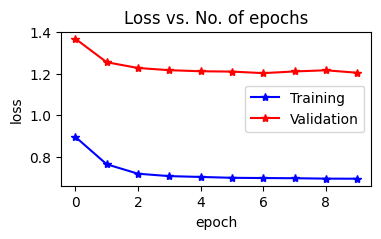

In [21]:
plot_losses(history)

In [22]:
#save our model
torch.save(model_gpu.state_dict(), 'model/24072023-autoencoder.pth')

# Evaluate the model using test dataset

In [23]:
result = evaluation(model_gpu, test_loader)
result

{'val_loss': 0.3902376592159271,
 'prediction': tensor([[9.5736e-04, 1.0343e-06, 9.9982e-08,  ..., 1.8753e-05, 4.6033e-05,
          8.4541e-08],
         [8.3210e-01, 1.7072e-05, 6.0244e-07,  ..., 1.6510e-03, 2.2397e-04,
          3.5990e-07],
         [2.2803e-04, 7.0814e-07, 8.2541e-08,  ..., 1.0019e-05, 3.9855e-05,
          6.5018e-08],
         ...,
         [9.9784e-01, 1.9879e-01, 7.3738e-02,  ..., 1.4483e-03, 8.5116e-01,
          9.0775e-06],
         [8.3292e-01, 8.2458e-01, 7.4283e-01,  ..., 5.2000e-03, 9.9015e-01,
          8.5604e-06],
         [7.2271e-01, 8.8971e-01, 8.7848e-01,  ..., 3.1119e-03, 9.9431e-01,
          1.2483e-05]], device='cuda:0')}

In [24]:
total_pred_test = (result['prediction']).cpu().numpy()
x_test_arr = x_test.to_numpy()

In [25]:
total_pred_test

array([[9.5736410e-04, 1.0343125e-06, 9.9982095e-08, ..., 1.8753213e-05,
        4.6032521e-05, 8.4541263e-08],
       [8.3209580e-01, 1.7072060e-05, 6.0244406e-07, ..., 1.6510291e-03,
        2.2396813e-04, 3.5989854e-07],
       [2.2802895e-04, 7.0813979e-07, 8.2540978e-08, ..., 1.0019347e-05,
        3.9854869e-05, 6.5018028e-08],
       ...,
       [9.9784434e-01, 1.9879226e-01, 7.3737942e-02, ..., 1.4482959e-03,
        8.5116273e-01, 9.0774702e-06],
       [8.3291721e-01, 8.2458103e-01, 7.4282700e-01, ..., 5.1999739e-03,
        9.9014854e-01, 8.5603833e-06],
       [7.2270805e-01, 8.8970560e-01, 8.7848020e-01, ..., 3.1118605e-03,
        9.9430817e-01, 1.2482742e-05]], dtype=float32)

In [26]:
x_test_arr

array([[ 0.28398623, -0.23366396, -0.25490663, ..., -0.27740744,
         0.23750713, -0.35256149],
       [ 0.32928245, -0.2810212 , -0.26731731, ..., -0.33356402,
         0.17667963, -0.3967209 ],
       [ 0.44687536, -0.44271784, -0.29135796, ..., -0.52024965,
        -0.04370619, -0.61944266],
       ...,
       [ 1.34089182, -0.03188539,  0.28427213, ..., -0.53835494,
         0.71052372, -0.9002333 ],
       [ 1.42038178,  0.50853343,  0.75422417, ..., -0.36427684,
         1.19018639, -0.85038387],
       [ 1.46929928,  0.84848729,  1.08868496, ..., -0.27916495,
         1.40414998, -0.85100655]])

In [27]:
pred_target_error = [mean_squared_error(total_pred_test[i],x_test_arr[i]) for i in range(len(total_pred_test))]

auc value: 0.6078009344929682


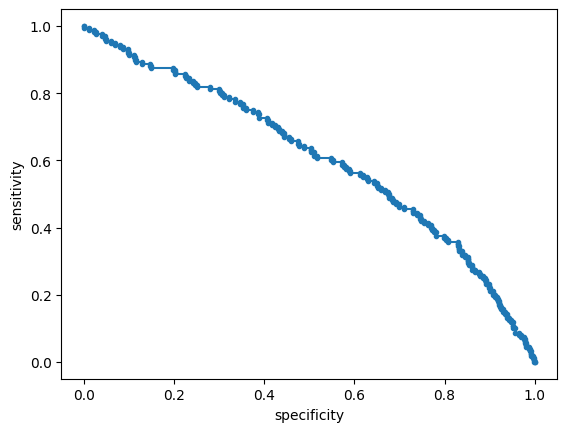

In [28]:
# ROC calculation
fpr, tpr, thresholds  = roc_curve(y_test, np.ravel(pred_target_error))    #compare annotaion file labels with classifier prediction result 
sensitivity = tpr
specificity = 1-fpr

plt.plot(specificity, sensitivity, marker='.')
#plt.title('ROC cureve of RF classifer')
plt.xlabel('specificity')
plt.ylabel('sensitivity')
auc_value = metrics.auc(fpr, tpr)
print('auc value:', auc_value)

# plt.savefig('./photos/roc-RF.png')
plt.show()